# Final models

The purpose of this notebook is to collect "final versions" of the models we want to use for ensembling. These will all use the same data (though they can certainly omit columns if you want). The point is to go from zero-to-trained model in one notebook so we can make sure everything looks good.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from utils.data_loader import Dataset

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, concatenate
from tensorflow.keras.layers.experimental import preprocessing

import xgboost as xgb

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier

## Data loading

Load the data here. Models below can augment it if need-be (for example the neural net needs it as a tensorflow dataset).

In [2]:
df = pd.read_csv('../data/start_to_finish.csv')  #Pct Diff Columns Only (Gives Highest Accuracy)
# df = pd.read_csv('../data/Final Data/pct-diff-mlb-games.csv')  #Pct Diff Columns Only (Gives Highest Accuracy)
#df = pd.read_csv('../data/Final Data/diff-mlb-games.csv')    #Diff columns only
#df = pd.read_csv('../data/Final Data/full-diff-mlb-games.csv')    #All columns

cols = ['team_ops_pct_diff', 'obp_diff', 'team_obp_pct_diff',
       'home_Rank_offset1year', 'away_WHIP_offset1year', 'team_ERA_pct_diff',
       'home_win_diff_bayes', 'home_RD', 'team_bayes_pct_diff',
       'away_win_diff_bayes'] + ['Y', 'M', 'home_win', 'home_team', 'away_team']

# cols = ['home_win', 'home_team', 'away_team', 'Y', 'M', 'avg_pct_diff',
#        'obp_pct_diff', 'slg_pct_diff', 'team_ERA_pct_diff',
#        'team_WHIP_pct_diff', 'team_W-L_pct_diff', 'team_Rank_pct_diff',
#        'team_FP_pct_diff', 'team_R_pct_diff', 'team_RA_pct_diff', 'team_pytha_pct_diff',
#        'team_W-L_pct_diff', 'team_bayes_pct_diff', 'pitcher_WHIP_pct_diff',
#        'pitcher_ERA_pct_diff', 'pitcher_IP_pct_diff', 'team_ops_pct_diff',
#        'RD_pct_diff', 'FP_pct_diff', 'Rank_pct_diff', 'team_WPA_pct_diff', 'log_5']


def train_test_split(df, include_teams=False):
    if not include_teams:
        df = df.drop(['home_team', 'away_team'], axis='columns')
    
    train_df = df[df['Y'] <= 2015]
    test_df = df[df['Y'] > 2015]

    X_train = train_df.drop('home_win', axis=1)
    y_train = train_df.home_win

    X_test = test_df.drop('home_win', axis=1)
    y_test = test_df.home_win
    
    return X_train, y_train, train_df, X_test, y_test, test_df

In [3]:
X_train, y_train, train_df, X_test, y_test, test_df = train_test_split(df[cols])
X_train_all, _, train_df_all, X_test_all, _, test_df_all = train_test_split(df)
X_train_nn, _, train_df_nn, X_test_nn, _, test_df_nn = train_test_split(df[cols], include_teams=True)

## Data cleaning

In [4]:
def fill_na_inf(df):
    for c in df.columns:
        if df[c].isin([-np.inf, np.inf]).sum() > 0:
            df[c] = df[c].replace([-np.inf, np.inf], None)
        if df[c].isna().sum() > 0:
            med = df[c].median()
            df[c] = df[c].fillna(med)
    return df

In [5]:
# data with cols
train_df = fill_na_inf(train_df)
test_df = fill_na_inf(test_df)

X_train = fill_na_inf(X_train)
X_test = fill_na_inf(X_test)

# data with _all_ columns
train_df_all = fill_na_inf(train_df_all)
test_df_all = fill_na_inf(test_df_all)

X_train_all = fill_na_inf(X_train_all)
X_test_all = fill_na_inf(X_test_all)

# nn data
train_df_nn = fill_na_inf(train_df_nn)
test_df_nn = fill_na_inf(test_df_nn)

X_train_nn = fill_na_inf(X_train_nn)
X_test_nn = fill_na_inf(X_test_nn)

## XGBoost with all columns

In [6]:
params = {'n_estimators': 100,
         'max_depth': 5,
         'min_child_weight': 0.3256355793000354,
         'eta': 0.3076951770384403,
         'subsample': 0.8242904472901268,
         'colsample_bytree': 0.9475703665037462,
         'gamma': 9.66425615956974,
         'seed': 0,
         'nthread': 4,
         'objective': 'binary:logistic',
         'eval_metric': 'auc'}

params40 = {'n_estimators': 100,
             'max_depth': 3,
             'min_child_weight': 6.292249181210905,
             'eta': 1.0,
             'subsample': 1.0,
             'colsample_bytree': 1.0,
             'gamma': 6.4258711159875235,
             'seed': 0,
             'nthread': 4,
             'objective': 'binary:logistic',
             'eval_metric': 'auc'}

In [7]:
xgb_clf = xgb.XGBClassifier(**params)

In [8]:
xgb_clf.fit(X_train_all, y_train)

/Users/psavala/.virtualenvs/baseball/lib/python3.8/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9475703665037462,
              eta=0.3076951770384403, eval_metric='auc', gamma=9.66425615956974,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.30769518, max_delta_step=0, max_depth=5,
              min_child_weight=0.3256355793000354, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4, nthread=4,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, seed=0, subsample=0.8242904472901268,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [9]:
xgb_preds = xgb_clf.predict(X_test_all)
xgb_proba_preds = xgb_clf.predict_proba(X_test_all)

test_acc = accuracy_score(y_test, xgb_preds)
print(f'Test acc = {100*test_acc:.2f}%')

Test acc = 61.08%


In [10]:
print(classification_report(y_test, xgb_preds))

              precision    recall  f1-score   support

         0.0       0.60      0.53      0.56      4656
         1.0       0.62      0.68      0.65      5282

    accuracy                           0.61      9938
   macro avg       0.61      0.61      0.61      9938
weighted avg       0.61      0.61      0.61      9938



### Feature Importance

In [11]:
featuredf = pd.DataFrame(xgb_clf.feature_importances_, X_train_all.columns)   #This makes it in order
featuredf = featuredf.sort_values(by=0, ascending=False)

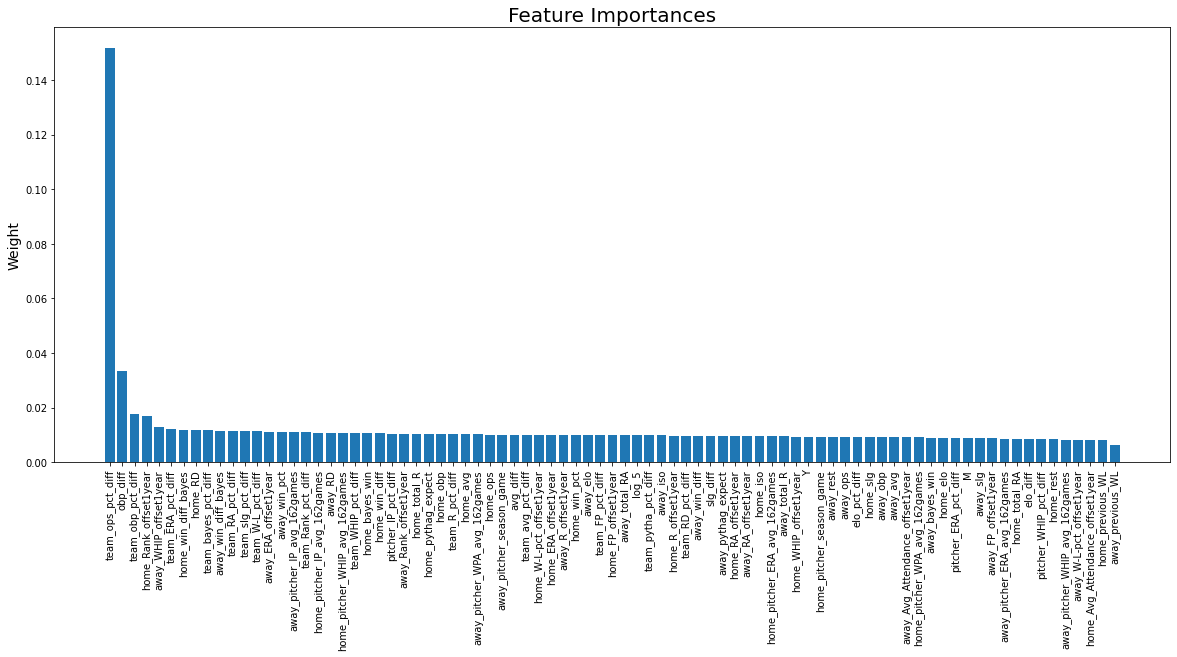

In [12]:
plt.figure(figsize=(20, 8))

x = featuredf.index
y = featuredf[0]

plt.bar(x, y)
plt.xticks(rotation=90)
plt.title('Feature Importances', fontsize=20)
plt.ylabel('Weight', fontsize=14);

In [13]:
top_cols = featuredf.iloc[:40].index

In [14]:
top_cols

Index(['team_ops_pct_diff', 'obp_diff', 'team_obp_pct_diff',
       'home_Rank_offset1year', 'away_WHIP_offset1year', 'team_ERA_pct_diff',
       'home_win_diff_bayes', 'home_RD', 'team_bayes_pct_diff',
       'away_win_diff_bayes', 'team_RA_pct_diff', 'team_slg_pct_diff',
       'team_W-L_pct_diff', 'away_ERA_offset1year', 'away_win_pct',
       'away_pitcher_IP_avg_162games', 'team_Rank_pct_diff',
       'home_pitcher_IP_avg_162games', 'away_RD',
       'home_pitcher_WHIP_avg_162games', 'team_WHIP_pct_diff',
       'home_bayes_win', 'home_win_diff', 'pitcher_IP_pct_diff',
       'away_Rank_offset1year', 'home_total_R', 'home_pythag_expect',
       'home_obp', 'team_R_pct_diff', 'home_avg',
       'away_pitcher_WPA_avg_162games', 'home_ops', 'away_pitcher_season_game',
       'avg_diff', 'team_avg_pct_diff', 'home_W-L-pct_offset1year',
       'home_ERA_offset1year', 'away_R_offset1year', 'home_win_pct',
       'away_elo'],
      dtype='object')

## XGB with top N columns

Try rerunning XGB using only the top N columns (ordered by feature importance when using all columns) to find where the cutoff should be by measuring test set accuracy on XGB. Obviously this is using the same fixed hyperparameters, which may not be ideal, but it's a start.

In [15]:
test_acc_list = []

for N in range(1, featuredf.shape[0]):
    cols = featuredf.iloc[:N].index
    xgb_topN_clf = xgb.XGBClassifier(**params40)
    xgb_topN_clf.fit(X_train_all[cols], y_train)
    xgb_topN_preds = xgb_topN_clf.predict(X_test_all[cols])
    xgb_topN_proba_preds = xgb_topN_clf.predict_proba(X_test_all[cols])

    test_acc = accuracy_score(y_test, xgb_topN_preds)
    test_acc_list.append(test_acc)
    print(f'N = {N}, acc = {100*test_acc:.2f}%')

N = 1, acc = 61.75%
N = 2, acc = 62.21%
N = 3, acc = 62.16%
N = 4, acc = 62.50%
N = 5, acc = 61.97%
N = 6, acc = 62.40%
N = 7, acc = 62.31%
N = 8, acc = 61.86%
N = 9, acc = 61.82%
N = 10, acc = 61.70%
N = 11, acc = 61.71%
N = 12, acc = 61.22%
N = 13, acc = 61.63%
N = 14, acc = 61.89%
N = 15, acc = 62.09%
N = 16, acc = 61.55%
N = 17, acc = 61.55%
N = 18, acc = 62.07%
N = 19, acc = 62.06%
N = 20, acc = 62.22%
N = 21, acc = 60.58%
N = 22, acc = 61.95%
N = 23, acc = 61.42%
N = 24, acc = 61.27%
N = 25, acc = 61.27%
N = 26, acc = 61.35%
N = 27, acc = 60.30%
N = 28, acc = 61.60%
N = 29, acc = 61.09%
N = 30, acc = 60.27%
N = 31, acc = 61.56%
N = 32, acc = 60.62%
N = 33, acc = 60.98%
N = 34, acc = 60.46%
N = 35, acc = 60.29%
N = 36, acc = 60.37%
N = 37, acc = 61.50%
N = 38, acc = 61.15%
N = 39, acc = 60.09%
N = 40, acc = 60.66%
N = 41, acc = 59.21%
N = 42, acc = 61.32%
N = 43, acc = 59.75%
N = 44, acc = 60.08%
N = 45, acc = 60.40%
N = 46, acc = 58.76%
N = 47, acc = 60.54%
N = 48, acc = 60.99%
N

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(range(1, featuredf.shape[0]), test_acc_list)
plt.xlabel('N')
plt.ylabel('XGB accuracy')
plt.title('Test set XGB accuracy using top N columns');

## XGB with top 10 columns

In [16]:
xgb_top10_clf = xgb.XGBClassifier(**params)
xgb_top10_clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9475703665037462,
              eta=0.3076951770384403, eval_metric='auc', gamma=9.66425615956974,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.30769518, max_delta_step=0, max_depth=5,
              min_child_weight=0.3256355793000354, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4, nthread=4,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, seed=0, subsample=0.8242904472901268,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [17]:
xgb_top10_preds = xgb_top10_clf.predict(X_test)
xgb_top10_proba_preds = xgb_top10_clf.predict_proba(X_test)

test_acc = accuracy_score(y_test, xgb_top10_preds)
print(f'Test acc = {100*test_acc:.2f}%')

Test acc = 62.38%


## KNN

In [18]:
ss = StandardScaler()
ss.fit(pd.concat([X_train, X_test]))
X_train_scaled = ss.transform(X_train)
X_test_scaled = ss.transform(X_test)

In [22]:
knn_cols = list(cols).copy()
for c in ['home_team', 'away_team', 'home_win']:
    if c in knn_cols:
        knn_cols.remove(c)

X_train_scaled = pd.DataFrame(X_train_scaled, columns=knn_cols)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=knn_cols)

# train_df_scaled = X_train_scaled.copy()
# train_df_scaled['home_win'] = y_train

# test_df_scaled = X_test_scaled.copy()
# test_df_scaled['home_win'] = y_test

ValueError: Shape of passed values is (37193, 12), indices imply (37193, 61)

In [ ]:
knn_clf = KNeighborsClassifier(150)
knn_clf.fit(X_train_scaled, y_train)

knn_preds = knn_clf.predict(X_test_scaled)
knn_proba_preds = knn_clf.predict_proba(X_test_scaled)

accuracy_score(y_test, knn_preds)

In [ ]:
print(classification_report(y_test, knn_preds))

## KNN without hitting (OPS, OBP, AVG, SLG)

Try training KNN with `ops_pct_diff`, `obp_pct_diff`, `avg_pct_diff` and `slg_pct_diff` removed (all hitting stats).

In [ ]:
cols_to_drop = ['team_ops_pct_diff', 'team_obp_pct_diff', 'team_slg_pct_diff', 'team_avg_pct_diff']
cols_to_drop = list(set(X_train_scaled.columns).intersection(set(cols_to_drop)))
X_train_scaled_no_ops = X_train_scaled.drop(cols_to_drop, axis='columns')
X_test_scaled_no_ops = X_test_scaled.drop(cols_to_drop, axis='columns')

In [ ]:
knn_no_ops_clf = KNeighborsClassifier(150)
knn_no_ops_clf.fit(X_train_scaled_no_ops, y_train)

knn_no_ops_preds = knn_no_ops_clf.predict(X_test_scaled_no_ops)
knn_no_ops_proba_preds = knn_no_ops_clf.predict_proba(X_test_scaled_no_ops)

accuracy_score(y_test, knn_no_ops_preds)

## Neural net

### Prepare layers

In [23]:
def get_normalization_layer(name, dataset):
    # Create a Normalization layer for our feature.
    normalizer = preprocessing.Normalization()

    # Prepare a Dataset that only yields our feature.
    feature_ds = dataset.map(lambda x, y: x[name])

    # Learn the statistics of the data.
    normalizer.adapt(feature_ds)

    return normalizer

def get_category_encoding_layer(name, dataset, dtype, max_tokens=None):
    # Create a StringLookup layer which will turn strings into integer indices
    if dtype == 'string':
        index = preprocessing.StringLookup(max_tokens=max_tokens)
    else:
        index = preprocessing.IntegerLookup(max_values=max_tokens)

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])

    # Learn the set of possible values and assign them a fixed integer index.
    index.adapt(feature_ds)
    
    if name == 'home_team':
        print('home_team')
        print(index.get_vocabulary())
        
    if name == 'away_team':
        print('away_team')
        print(index.get_vocabulary())

    # Create a Discretization for our integer indices.
    encoder = preprocessing.CategoryEncoding(max_tokens=index.vocab_size())

    # Prepare a Dataset that only yields our feature.
    feature_ds = feature_ds.map(index)

    # Learn the space of possible indices.
    encoder.adapt(feature_ds)

    # Apply one-hot encoding to our indices. The lambda function captures the
    # layer so we can use them, or include them in the functional model later.
    return lambda feature: encoder(index(feature))

def prep_columns(dataset, embedding_dims=10, embedding_cols=None, numeric_cols=None):
    cont_inputs = []
    cat_inputs = []
    encoded_cont_features = []
    encoded_cat_features = []
    if isinstance(embedding_dims, int):
        embedding_dims = [embedding_dims] * len(embedding_cols)
    assert len(embedding_dims) == len(embedding_cols), 'embedding_dims must be an integer or a list with the same length as embedding_cols'

    # Numeric features.
    for header in numeric_cols:
        numeric_col = tf.keras.Input(shape=(1,), name=header)
        normalization_layer = get_normalization_layer(header, dataset)
        encoded_numeric_col = normalization_layer(numeric_col)
        encoded_numeric_col = tf.keras.layers.Dropout(0.1)(encoded_numeric_col)
        cont_inputs.append(numeric_col)
        encoded_cont_features.append(encoded_numeric_col)

    # Home and away teams
    for i, header in enumerate(['home_team', 'away_team']):
        categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='int64')
        encoded_categorical_col = tf.keras.layers.Embedding(30, embedding_dims[i], name=f'{header}_embedding')(categorical_col)
        encoded_categorical_col = tf.keras.layers.Flatten()(encoded_categorical_col)
        cat_inputs.append(categorical_col)
        encoded_cat_features.append(encoded_categorical_col)
        
    # Categorical features encoded as ints.
    encoded_embedding_cols = embedding_cols.copy()
    encoded_embedding_cols.remove('home_team')
    encoded_embedding_cols.remove('away_team')
    for i, header in enumerate(encoded_embedding_cols):
        categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='int64')
        encoding_layer = get_category_encoding_layer(header, dataset, 
                                                     dtype='int', 
                                                     max_tokens=20)
        encoded_categorical_col = encoding_layer(categorical_col)
        encoded_categorical_col = tf.keras.layers.Embedding(20, 5, name=f'{header}_embedding')(encoded_categorical_col)
        encoded_categorical_col = tf.keras.layers.Flatten()(encoded_categorical_col)
        cat_inputs.append(categorical_col)
        encoded_cat_features.append(encoded_categorical_col)
        
    all_inputs = cont_inputs + cat_inputs
        
    return all_inputs, encoded_cont_features, encoded_cat_features

### Make tensorflow dataset from data

In [24]:
def load_ds(df):
    cols_to_drop = ['home_pitcher', 'away_pitcher', 'date']
    cols_to_drop = list(set(df.columns).intersection(set(cols_to_drop)))
    df = df.drop(cols_to_drop, axis='columns')
    
    embedding_cols = ['home_team', 'away_team', 'Y', 'M']
    numeric_cols = list(set(df.columns) - set(embedding_cols))
    numeric_cols.remove('home_win')
    assert set(numeric_cols).intersection(set(embedding_cols)) == set()
    assert len(embedding_cols) + len(numeric_cols) + 1 == len(df.columns)
    
    df = fill_na_inf(df)
            
    le = LabelEncoder()
    df['away_team'] = le.fit_transform(df['away_team'])
    df['home_team'] = le.transform(df['home_team'])
    
    for c in embedding_cols:
        df[c] = df[c].astype(int)
        
    assert df.isna().sum().sum() == 0
    
    y = df.pop('home_win')
    y = y.astype(int)
    X = df
    
    tf_ds = tf.data.Dataset.from_tensor_slices((dict(X), y)).batch(128)
    return tf_ds, df, le, embedding_cols, numeric_cols

In [25]:
train_ds, tf_train_df, le, embedding_cols, numeric_cols = load_ds(train_df_nn)
test_ds, tf_test_df, _, _, _ = load_ds(test_df_nn)

In [26]:
all_inputs, encoded_cont_features, encoded_cat_features = prep_columns(train_ds,
                                                                       10,
                                                                       embedding_cols, 
                                                                       numeric_cols)

### Model

In [27]:
x = concatenate(encoded_cat_features + encoded_cont_features)
x = Dense(32, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(32, activation="relu")(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)
output = Dense(1)(x)
try:
    del model
except NameError:
    pass
model = tf.keras.Model(all_inputs, output)
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=["accuracy"])

In [28]:
model.fit(train_ds, epochs=30, validation_data=test_ds)

Epoch 1/30
291/291 [==============================] - 2s 4ms/step - loss: 0.7342 - accuracy: 0.5545 - val_loss: 0.6648 - val_accuracy: 0.5139
Epoch 2/30
291/291 [==============================] - 1s 4ms/step - loss: 0.6675 - accuracy: 0.5697 - val_loss: 0.6500 - val_accuracy: 0.5750
Epoch 3/30
291/291 [==============================] - 1s 4ms/step - loss: 0.6579 - accuracy: 0.5741 - val_loss: 0.6479 - val_accuracy: 0.5840
Epoch 4/30
291/291 [==============================] - 1s 3ms/step - loss: 0.6539 - accuracy: 0.5769 - val_loss: 0.6457 - val_accuracy: 0.5893
Epoch 5/30
291/291 [==============================] - 1s 3ms/step - loss: 0.6509 - accuracy: 0.5791 - val_loss: 0.6452 - val_accuracy: 0.5896
Epoch 6/30
291/291 [==============================] - 1s 4ms/step - loss: 0.6480 - accuracy: 0.5834 - val_loss: 0.6452 - val_accuracy: 0.5916
Epoch 7/30
291/291 [==============================] - 1s 3ms/step - loss: 0.6470 - accuracy: 0.5839 - val_loss: 0.6457 - val_accuracy: 0.5871
Epoch 

In [29]:
loss, acc = model.evaluate(test_ds)
print(f'Test accuracy = {100*acc:.2f}%')

78/78 [==============================] - 0s 3ms/step - loss: 0.6519 - accuracy: 0.5809
Test accuracy = 58.09%


In [30]:
nn_logit_preds = model.predict(test_ds).squeeze()
nn_softmax_preds = tf.nn.sigmoid(nn_logit_preds)
nn_preds = tf.round(nn_softmax_preds).numpy()

## Monthly accuracy

Compare the monthly accuracy for all models.

In [ ]:
def monthly_accuracy(model, df, is_tf=False):
    monthly_acc = []
    months_list = np.sort(df['M'].unique())
    for months in months_list:
        test_month = df[df['M'] == months]

        y_test_month = test_month.pop('home_win')
        X_test_month = test_month

        if is_tf:
            tf_ds = tf.data.Dataset.from_tensor_slices((dict(X_test_month), y_test_month)).batch(128)
            test_logits = model.predict(tf_ds).squeeze()
            pred = tf.round(tf.nn.sigmoid(test_logits)).numpy()
        else:
            pred = model.predict(X_test_month)
        acc = accuracy_score(y_test_month, pred)

        monthly_acc.append(acc)

    monthly_acc = pd.DataFrame(monthly_acc)
    
    return monthly_acc

In [ ]:
xgb_month = monthly_accuracy(xgb_clf, test_df)
knn_month = monthly_accuracy(knn_clf, test_df_scaled)
knn_no_ops_month = monthly_accuracy(knn_no_ops_clf, test_df_scaled.drop('ops_pct_diff', axis=1))
tf_test_df['home_win'] = y_test
nn_month = monthly_accuracy(model, tf_test_df, is_tf=True)

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(xgb_month[0]*100, label='XGB')
plt.plot(knn_month[0]*100, label='KNN')
plt.plot(nn_month[0]*100, label='NN')
plt.ylabel('Accuracy', fontsize=16)
plt.xticks(range(8), ['March','April', 'May', 'June','July', 'August', 'September', 'October'])
plt.legend();

## Negative stats

Consider stats like `ops_pct_diff` where a positive value is a strong indicator of a win for the home team. In the case where these stats are _negative_ and yet the home team still wins (or positive but the away team wins), how is each model performing?

In [ ]:
tf_test_df['home_win'] = y_test

In [ ]:
tf_test_df.head()

In [ ]:
def negative_stats_acc(df, col, reverse=False):
    if not reverse:
        unusual_df = df[((df[col] > 0) & (df['home_win'] == 0)) | ((df[col] < 0) & (df['home_win'] == 1))]
    else:
        unusual_df = df[((df[col] < 0) & (df['home_win'] == 0)) | ((df[col] > 0) & (df['home_win'] == 1))]
    
    xgb_acc = (unusual_df['xgb_pred'] == unusual_df['home_win']).sum() / unusual_df.shape[0]
    nn_acc = (unusual_df['nn_pred'] == unusual_df['home_win']).sum() / unusual_df.shape[0]
    knn_acc = (unusual_df['knn_pred'] == unusual_df['home_win']).sum() / unusual_df.shape[0]
    knn_no_ops_acc = (unusual_df['knn_no_ops_pred'] == unusual_df['home_win']).sum() / unusual_df.shape[0]
    
    print(f'{"="*10} {col} {"="*10}')
    print(f'XGB acc = {100*xgb_acc:.2f}%')
    print(f'NN acc = {100*nn_acc:.2f}%')
    print(f'KNN acc = {100*knn_acc:.2f}%')
    print(f'KNN (no OPS) acc = {100*knn_no_ops_acc:.2f}%')

In [ ]:
reverse_cols = ['team_ERA_pct_diff', 'pitcher_ERA_pct_diff', 'team_WHIP_pct_diff',
                'pitcher_WHIP_pct_diff', 'team_Rank_pct_diff', 'Rank_pct_diff']
pct_diff_cols = [c for c in tf_test_df.columns if c.endswith('_pct_diff')]

In [ ]:
for c in reverse_cols:
    pct_diff_cols.remove(c)

In [ ]:
for c in pct_diff_cols:
    negative_stats_acc(tf_test_df, c)

In [ ]:
for c in reverse_cols:
    negative_stats_acc(tf_test_df, c, reverse=True)

## Ensembling

In [ ]:
assert xgb_top10_preds.shape == knn_preds.shape == nn_preds.shape == knn_no_ops_preds.shape == y_test.shape

In [ ]:
print('Individual model accuracy:')
print(f'XGB: {100*accuracy_score(y_test, xgb_preds):.2f}%')
print(f'KNN: {100*accuracy_score(y_test, knn_preds):.2f}%')
print(f'KNN (no hitting): {100*accuracy_score(y_test, knn_no_ops_preds):.2f}%')
print(f'NN: {100*accuracy_score(y_test, nn_preds):.2f}%')       

### Correlation between models

In [ ]:
from itertools import combinations

preds_names = ['XGB (all)', 'XGB (top 10)', 'KNN (top 10)', 'KNN (top 10, no hitting)', 'NN (top 10)']
preds_list = [xgb_preds, xgb_top10_preds, knn_preds, knn_no_ops_preds, nn_preds]

for idx1, idx2 in combinations(range(len(preds_list)), 2):
    model1 = preds_list[idx1]
    model2 = preds_list[idx2]
    disagree = np.sum(model1 != model2)
    print(f'{preds_names[idx1]} <-> {preds_names[idx2]}: {disagree} disagreed on')
    
    num_correct = 0
    for i in range(y_test.shape[0]):
        if y_test.values[i] in [model1[i], model2[i]]:
            num_correct += 1

    print(f'Maximum possible accuracy = {100*num_correct / y_test.shape[0]:.2f}%')
    print('='*40)

In [ ]:
for idx1, idx2, idx3 in combinations(range(len(preds_list)), 3):
    model1 = preds_list[idx1]
    model2 = preds_list[idx2]
    model3 = preds_list[idx3]

    num_correct = 0
    for i in range(y_test.shape[0]):
        if y_test.values[i] in [model1[i], model2[i], model3[i]]:
            num_correct += 1
    print(f'{preds_names[idx1]}, {preds_names[idx2]}, {preds_names[idx3]}')
    print(f'Maximum possible accuracy = {100*num_correct / y_test.shape[0]:.2f}%')
    print('='*40)

### Maximum possible accuracy

If we could always pick the "right" model for each row, what is the best possible test accuracy we could get from these three models?

In [ ]:
num_correct = 0

for i in range(y_test.shape[0]):
    if y_test.values[i] in [xgb_top10_preds[i], knn_no_ops_preds[i], nn_preds[i]]:
        num_correct += 1

print(f'Maximum possible accuracy = {100*num_correct / y_test.shape[0]:.2f}%')

### Majority voting

Just pick the prediction that the majority of the models voted for.

In [ ]:
num_correct = 0

for i in range(y_test.shape[0]):
    # Just add them up. If at least two models voted 1, then choose 1. Otherwise choose 0.
    majority_vote = np.sum([xgb_top10_preds[i], knn_no_ops_preds[i], nn_preds[i]])
    if majority_vote > 1:
        majority_vote = 1
    else:
        majority_vote = 0
    if y_test.values[i] == majority_vote:
        num_correct += 1

print(f'Majority voting accuracy = {100*num_correct / y_test.shape[0]:.2f}%')

### Number of positive columns
Choose a KNN when the number of positive columns (from list below) is < 5, and the NN when it's greater than 5. This work/idea comes from the `Comparing model predictions` notebook.

In [ ]:
pct_diff_cols = [c for c in cols if c.endswith('_pct_diff')]
pct_diff_reverse_cols = ['pitcher_WHIP_pct_diff', 'team_Rank_pct_diff', 
                         'team_WHIP_pct_diff', 'team_ERA_pct_diff', 'pitcher_ERA_pct_diff',
                         'team_RA_pct_diff']
pct_diff_reverse_cols = list(set(pct_diff_cols).intersection(pct_diff_reverse_cols))

for c in pct_diff_reverse_cols:
    pct_diff_cols.remove(c)

In [ ]:
num_correct = 0

for i in range(y_test.shape[0]):
    # Just add them up. If at least two models voted 1, then choose 1. Otherwise choose 0.
    vote = np.sum([knn_no_ops_preds[i], nn_preds[i]])
    if vote == 2:
        vote = 1
    elif vote == 0:
        vote = 0
    elif (test_df.iloc[i][pct_diff_cols] > 0).sum() >= 5:
        vote = knn_no_ops_preds[i]
    else:
        vote = nn_preds[i]
        
    if y_test.values[i] == vote:
        num_correct += 1

print(f'Majority voting accuracy = {100*num_correct / y_test.shape[0]:.2f}%')

In [ ]:
num_correct = 0

for i in range(y_test.shape[0]):
    # Just add them up. If at least two models voted 1, then choose 1. Otherwise choose 0.
    vote = np.sum([knn_no_ops_preds[i], nn_preds[i]])
    if vote == 2:
        vote = 1
    elif vote == 0:
        vote = 0
    elif (test_df.iloc[i][pct_diff_reverse_cols] < 0).sum() >= 4:
        vote = knn_no_ops_preds[i]
    else:
        vote = nn_preds[i]
        
    if y_test.values[i] == vote:
        num_correct += 1

print(f'Majority voting accuracy = {100*num_correct / y_test.shape[0]:.2f}%')

In [ ]:
num_correct = 0

for i in range(y_test.shape[0]):
    # Just add them up. If at least two models voted 1, then choose 1. Otherwise choose 0.
    vote = np.sum([knn_no_ops_preds[i], nn_preds[i]])
    if vote == 2:
        vote = 1
    elif vote == 0:
        vote = 0
    elif test_df.iloc[i]['team_bayes_pct_diff'] > 0:
        vote = nn_preds[i]
    else:
        vote = knn_no_ops_preds[i]
        
    if y_test.values[i] == vote:
        num_correct += 1

print(f'Majority voting accuracy = {100*num_correct / y_test.shape[0]:.2f}%')

## Recording predictions

Save a dataframe with the predictions for each model.

In [481]:
test_df_nn.head()

,team_ops_pct_diff,obp_diff,team_obp_pct_diff,home_Rank_offset1year,away_WHIP_offset1year,team_ERA_pct_diff,home_win_diff_bayes,home_RD,team_bayes_pct_diff,away_win_diff_bayes,...,away_pitcher_IP_avg_162games,team_Rank_pct_diff,home_pitcher_IP_avg_162games,away_RD,home_pitcher_WHIP_avg_162games,Y,M,home_win,home_team,away_team
37193,0.001479,0.001196,0.003769,2.0,1.253927,0.089783,-0.010464,101.0,0.0,-0.010464,...,5.485714,0.50,5.480001,122.0,1.390555,2016,4.0,1.0,PIT,SLN
37194,-0.100639,-0.023374,-0.075552,4.0,1.214434,-0.018717,-0.010464,2.0,0.0,-0.010464,...,5.485714,0.75,5.480001,221.0,1.390555,2016,4.0,0.0,TBA,TOR
37195,0.028053,0.009820,0.030927,1.0,1.179045,0.077540,-0.010464,83.0,0.0,-0.010464,...,5.485714,0.00,5.480001,70.0,1.390555,2016,4.0,1.0,KCA,NYN
37196,0.031095,0.006132,0.019876,5.0,1.320066,0.043269,-0.010464,-35.0,0.0,-0.010464,...,5.485714,0.20,5.480001,-79.0,1.390555,2016,4.0,0.0,OAK,CHA
37197,-0.026164,-0.014945,-0.049505,3.0,1.151872,0.147208,-0.010464,-14.0,0.0,-0.010464,...,5.485714,0.00,5.480001,81.0,1.390555,2016,4.0,0.0,ANA,CHN


In [ ]:
test_df_nn['home_team'] = le.inverse_transform(test_df_nn['home_team'])
test_df_nn['away_team'] = le.inverse_transform(test_df_nn['away_team'])

In [483]:
test_df_nn.head()

,team_ops_pct_diff,obp_diff,team_obp_pct_diff,home_Rank_offset1year,away_WHIP_offset1year,team_ERA_pct_diff,home_win_diff_bayes,home_RD,team_bayes_pct_diff,away_win_diff_bayes,...,away_pitcher_IP_avg_162games,team_Rank_pct_diff,home_pitcher_IP_avg_162games,away_RD,home_pitcher_WHIP_avg_162games,Y,M,home_win,home_team,away_team
37193,0.001479,0.001196,0.003769,2.0,1.253927,0.089783,-0.010464,101.0,0.0,-0.010464,...,5.485714,0.50,5.480001,122.0,1.390555,2016,4.0,1.0,PIT,SLN
37194,-0.100639,-0.023374,-0.075552,4.0,1.214434,-0.018717,-0.010464,2.0,0.0,-0.010464,...,5.485714,0.75,5.480001,221.0,1.390555,2016,4.0,0.0,TBA,TOR
37195,0.028053,0.009820,0.030927,1.0,1.179045,0.077540,-0.010464,83.0,0.0,-0.010464,...,5.485714,0.00,5.480001,70.0,1.390555,2016,4.0,1.0,KCA,NYN
37196,0.031095,0.006132,0.019876,5.0,1.320066,0.043269,-0.010464,-35.0,0.0,-0.010464,...,5.485714,0.20,5.480001,-79.0,1.390555,2016,4.0,0.0,OAK,CHA
37197,-0.026164,-0.014945,-0.049505,3.0,1.151872,0.147208,-0.010464,-14.0,0.0,-0.010464,...,5.485714,0.00,5.480001,81.0,1.390555,2016,4.0,0.0,ANA,CHN


In [485]:
test_df_nn['xgb_pred'] = xgb_preds
test_df_nn['knn_pred'] = knn_preds
test_df_nn['knn_no_batting_pred'] = knn_no_ops_preds
test_df_nn['nn_pred'] = nn_preds
test_df_nn['nn_pred'] = test_df_nn['nn_pred'].astype(int)

test_df_nn['xgb_proba'] = xgb_proba_preds[:, 1]
test_df_nn['knn_proba'] = knn_proba_preds[:, 1]
test_df_nn['knn_no_batting_proba'] = knn_no_ops_proba_preds[:, 1]
test_df_nn['nn_proba'] = nn_softmax_preds.numpy()

In [486]:
test_df_nn.head()

,team_ops_pct_diff,obp_diff,team_obp_pct_diff,home_Rank_offset1year,away_WHIP_offset1year,team_ERA_pct_diff,home_win_diff_bayes,home_RD,team_bayes_pct_diff,away_win_diff_bayes,...,home_team,away_team,xgb_pred,knn_pred,knn_no_batting_pred,nn_pred,xgb_proba,knn_proba,knn_no_batting_proba,nn_proba
37193,0.001479,0.001196,0.003769,2.0,1.253927,0.089783,-0.010464,101.0,0.0,-0.010464,...,PIT,SLN,0.0,0.0,1.0,0,0.452681,0.500000,0.520000,0.455505
37194,-0.100639,-0.023374,-0.075552,4.0,1.214434,-0.018717,-0.010464,2.0,0.0,-0.010464,...,TBA,TOR,0.0,0.0,1.0,0,0.377228,0.473333,0.506667,0.395637
37195,0.028053,0.009820,0.030927,1.0,1.179045,0.077540,-0.010464,83.0,0.0,-0.010464,...,KCA,NYN,1.0,1.0,1.0,1,0.629717,0.533333,0.546667,0.508145
37196,0.031095,0.006132,0.019876,5.0,1.320066,0.043269,-0.010464,-35.0,0.0,-0.010464,...,OAK,CHA,1.0,0.0,1.0,1,0.572504,0.486667,0.506667,0.525333
37197,-0.026164,-0.014945,-0.049505,3.0,1.151872,0.147208,-0.010464,-14.0,0.0,-0.010464,...,ANA,CHN,1.0,0.0,0.0,0,0.515874,0.486667,0.486667,0.497620


In [487]:
test_df_nn.to_csv('../data/Final Data/start_to_finish_with_preds.csv', index=False)

### For Training Predictions

In [ ]:
xgb_train_pred = xgb_clf.predict(X_train)
knn_no_train_pred = knn_no_ops_clf.predict(X_train_scaled_no_ops)
nn_train_logit_preds = model.predict(train_ds).squeeze()
nn_train_softmax_preds = tf.nn.sigmoid(nn_train_logit_preds)
nn_train_pred = tf.round(nn_train_softmax_preds).numpy()

In [ ]:
tf_train_df['home_team'] = le.inverse_transform(tf_train_df['home_team'])
tf_train_df['away_team'] = le.inverse_transform(tf_train_df['away_team'])

In [ ]:
tf_train_df['xgb_train_pred'] = xgb_train_pred
tf_train_df['knn_no_batting_train_pred'] = knn_no_train_pred
tf_train_df['nn_train_pred'] = nn_train_pred
tf_train_df['nn_train_pred'] = tf_train_df['nn_train_pred'].astype(int)

In [ ]:
tf_train_df['home_win'] = y_train

In [ ]:
tf_train_df.to_csv('../data/Final Data/training_with_preds.csv', index=False)

## Win count error

Following the idea on [this site](https://www.bettingpros.com/articles/most-accurate-2019-mlb-futures-analysts/), how does our error compare to human pickers?

In [41]:
test_df_nn['xgb_pred'] = xgb_preds

In [47]:
home_wins = test_df_nn[test_df_nn['Y']==2019].groupby(['home_team'])['home_win'].sum()

In [52]:
away_wins = 162 - test_df_nn[test_df_nn['Y']==2019].groupby(['away_team'])['home_win'].sum()

In [53]:
home_wins + away_wins

home_team
ANA    152.0
ARI    166.0
ATL    177.0
BAL    130.0
BOS    164.0
CHA    157.0
CHN    165.0
CIN    154.0
CLE    177.0
COL    150.0
DET    126.0
HOU    187.0
KCA    141.0
LAN    187.0
MIA    136.0
MIL    170.0
MIN    183.0
NYA    193.0
NYN    168.0
OAK    176.0
PHI    158.0
PIT    149.0
SDN    151.0
SEA    149.0
SFN    158.0
SLN    176.0
TBA    172.0
TEX    160.0
TOR    148.0
WAS    180.0
Name: home_win, dtype: float64

In [55]:
test_df_nn[test_df_nn['Y']==2019]['home_team'].value_counts()

NYA    91
CHA    88
WAS    87
SLN    87
CLE    87
BAL    85
BOS    85
TEX    85
KCA    85
DET    85
MIN    83
NYN    83
COL    83
CIN    83
TBA    83
PHI    81
SEA    81
ARI    81
LAN    81
OAK    81
SFN    81
TOR    81
MIA    81
CHN    81
ATL    81
HOU    81
MIL    81
ANA    81
PIT    81
SDN    81
Name: home_team, dtype: int64

In [56]:
test_df_nn[test_df_nn['Y']==2019]['away_team'].value_counts()

BAL    89
TBA    89
DET    88
MIN    85
CIN    85
NYA    85
PHI    85
MIA    83
COL    83
OAK    83
TEX    83
ANA    83
NYN    83
BOS    83
CHA    83
SFN    83
ATL    83
KCA    83
HOU    83
PIT    83
CHN    81
CLE    81
TOR    81
WAS    81
SLN    81
LAN    81
SEA    81
ARI    81
MIL    81
SDN    81
Name: away_team, dtype: int64